1. Необходимые функции

In [53]:
import pandas as pd
import json

def read_file(file_name):
    return pd.read_csv(file_name, compression="zip", low_memory=False)
    # return next()


def get_memory_stat_by_column(read_and_optimized):
    memory_usage_stat = read_and_optimized.memory_usage(deep=True)
    total_memory_usage = memory_usage_stat.sum()
    print(f"file in memory size = {total_memory_usage // 1024:10} КБ")
    column_stat = list()
    for key in read_and_optimized.dtypes.keys():
        column_stat.append({
            "column_name": key,
            "memory_abs": memory_usage_stat[key] // 1024,
            "memory_per": round(memory_usage_stat[key] / total_memory_usage * 100, 4),
            "dtype": read_and_optimized.dtypes[key]
        })
    column_stat.sort(key=lambda x: x['memory_abs'], reverse=True)
    for column in column_stat:
        print(
            f"{column['column_name']:30}: {column['memory_abs']:10} КБ: {column['memory_per']:10}% : {column['dtype']}")


def mem_usage(pandas_obj):
    if isinstance(pandas_obj, pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else:  # предположим, что если это не датафрейм, то серия
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2  # преобразуем байты в мегабайты
    return "{:03.2f} MB".format(usage_mb)


def opt_obj(read_and_optimized):
    converted_obj = pd.DataFrame()
    dataset_obj = read_and_optimized.select_dtypes(include=['object']).copy()

    for col in dataset_obj.columns:
        num_unique_values = len(dataset_obj[col].unique())
        num_total_values = len(dataset_obj[col])
        if num_unique_values / num_total_values < 0.5:
            converted_obj.loc[:, col] = dataset_obj[col].astype('category')
        else:
            converted_obj.loc[:, col] = dataset_obj[col]

    print(mem_usage(dataset_obj))
    print(mem_usage(converted_obj))
    return converted_obj


def opt_int(read_and_optimized):
    dataset_int = read_and_optimized.select_dtypes(include=['int'])
    """
    downcast:
            - 'integer' or 'signed': smallest signed int dtype (min.: np.int8)
            - 'unsigned': smallest unsigned int dtype (min.: np.uint8)
            - 'float': smallest float dtype (min.: np.float32)
    """
    converted_int = dataset_int.apply(pd.to_numeric, downcast='unsigned')
    print(mem_usage(dataset_int))
    print(mem_usage(converted_int))
    #
    compare_ints = pd.concat([dataset_int.dtypes, converted_int.dtypes], axis=1)
    compare_ints.columns = ['before', 'after']
    compare_ints.apply(pd.Series.value_counts)
    print(compare_ints)

    return converted_int


def opt_float(read_and_optimized):
    # # =======================================================================
    # # выполняем понижающее преобразование
    # # для столбцов типа float
    dataset_float = read_and_optimized.select_dtypes(include=['float'])
    converted_float = dataset_float.apply(pd.to_numeric, downcast='float')

    print(mem_usage(dataset_float))
    print(mem_usage(converted_float))

    compare_floats = pd.concat([dataset_float.dtypes, converted_float.dtypes], axis=1)
    compare_floats.columns = ['before', 'after']
    compare_floats.apply(pd.Series.value_counts)
    print(compare_floats)

    return converted_float



In [ ]:
# steps 1-3
file_name = "./RF_Signal_Dataset.zip"
dataset = read_file(file_name)
get_memory_stat_by_column(dataset)

# steps 4-6
optimized_dataset = dataset.copy()

converted_obj = opt_obj(dataset)
converted_int = opt_int(dataset)
converted_float = opt_float(dataset)
#
optimized_dataset[converted_obj.columns] = converted_obj
optimized_dataset[converted_int.columns] = converted_int
optimized_dataset[converted_float.columns] = converted_float

for col in optimized_dataset.select_dtypes(include='object').columns:
    unique_ratio = optimized_dataset[col].nunique() / len(optimized_dataset)
    if unique_ratio < 0.5:
        optimized_dataset[col] = optimized_dataset[col].astype('category')

# 7
get_memory_stat_by_column(dataset)
print(mem_usage(dataset))
print(mem_usage(optimized_dataset))
optimized_dataset.info(memory_usage='deep')
optimized_dataset.to_csv("./RF_Signal_Dataset_Optimized.csv")

# 8
# отобрать свои 10 колонок
need_column = dict()
column_names = ['Frequency', 'Signal Strength', 'Modulation',
                 'Bandwidth', 'Antenna Type', 'Temperature',
                 'Humidity', 'Device Type', 'Location', 'Air Pressure']
opt_dtypes = optimized_dataset.dtypes
for key in dataset.columns:
    need_column[key] = opt_dtypes[key]
    print(f"{key}:{opt_dtypes[key]}")

with open("dtypes_2_not_optimized.json", mode="w") as file:
    dtype_json = need_column.copy()
    for key in dtype_json.keys():
        dtype_json[key] = str(dtype_json[key])

    json.dump(dtype_json, file)

# 9

read_and_optimized = pd.read_csv(file_name, usecols=lambda x: x in column_names, dtype=need_column)



file in memory size =     574941 КБ
I/Q Data                      :     467304 КБ:    81.2786% : object
Timestamp                     :      12183 КБ:     2.1191% : object
Device Status                 :      12127 КБ:     2.1094% : object
Location                      :      11061 КБ:     1.9239% : object
Antenna Type                  :      10581 КБ:     1.8404% : object
Device Type                   :      10313 КБ:     1.7938% : object
Weather Condition             :       9992 КБ:      1.738% : object
Interference Type             :       9767 КБ:     1.6989% : object
Modulation                    :       9645 КБ:     1.6776% : object
Frequency                     :       1282 КБ:     0.2231% : int64
Signal Strength               :       1282 КБ:     0.2231% : int64
Bandwidth                     :       1282 КБ:     0.2231% : int64
Temperature                   :       1282 КБ:     0.2231% : int64
Humidity                      :       1282 КБ:     0.2231% : int64
Wind Speed       

In [55]:
read_and_optimized

,Frequency,Signal Strength,Modulation,Bandwidth,Location,Device Type,Antenna Type,Temperature,Humidity,Air Pressure
0,120000000,-44,QAM,50000,"Patna, Bihar",HackRF,Yagi,24,47,NaN
1,160000000,-97,FM,1000000,"Patna, Bihar",HackRF,Yagi,27,39,NaN
2,90000000,-87,BPSK,500000,"Patna, Bihar",Halow-U,Yagi,40,58,NaN
3,160000000,-29,FM,100000,"Patna, Bihar",Halow-U,Dipole,28,50,NaN
4,70000000,-26,8PSK,10000,"Patna, Bihar",HackRF,Omnidirectional,22,78,NaN
...,...,...,...,...,...,...,...,...,...,...
164155,160000000,-63,BPSK,200000,"Patna, Bihar",SteamDeck,Yagi,31,44,NaN
164156,120000000,-15,QAM,10000,"Patna, Bihar",Halow-U,Omnidirectional,28,30,NaN
164157,160000000,-97,FM,10000,"Patna, Bihar",Halow-U,Yagi,25,30,NaN
164158,120000000,-29,AM,500000,"Patna, Bihar",SteamDeck,Yagi,28,41,NaN


<Figure size 1000x600 with 0 Axes>

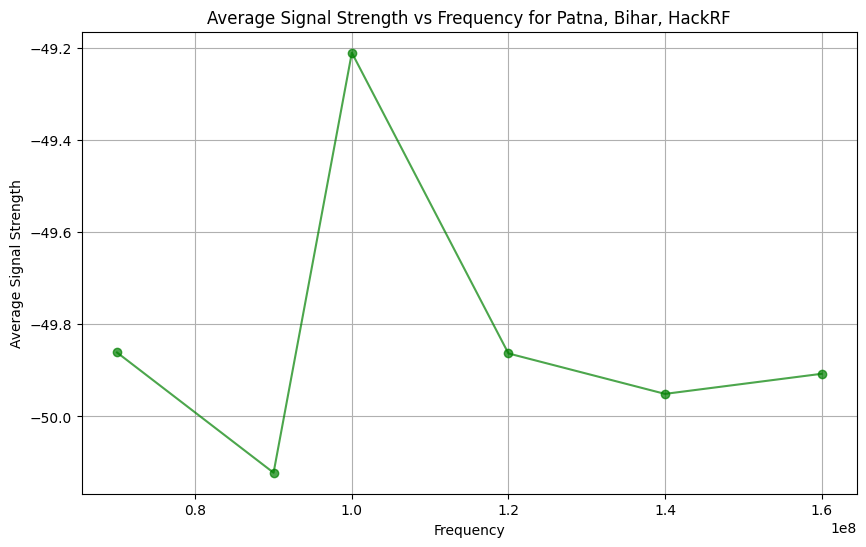

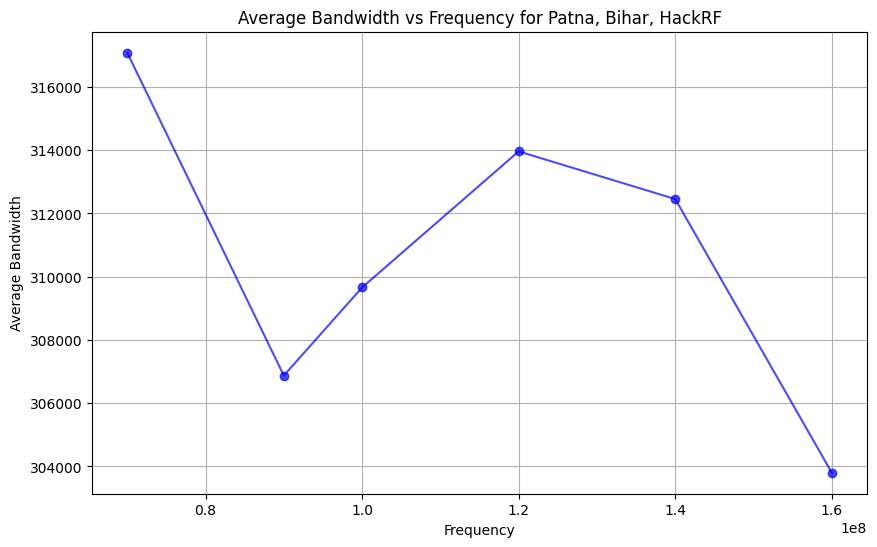

C:\Users\Mitya\AppData\Local\Temp\ipykernel_3248\3589983061.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_signal_strength = filtered_read_and_optimized.groupby('Modulation')['Signal Strength'].mean().sort_values()


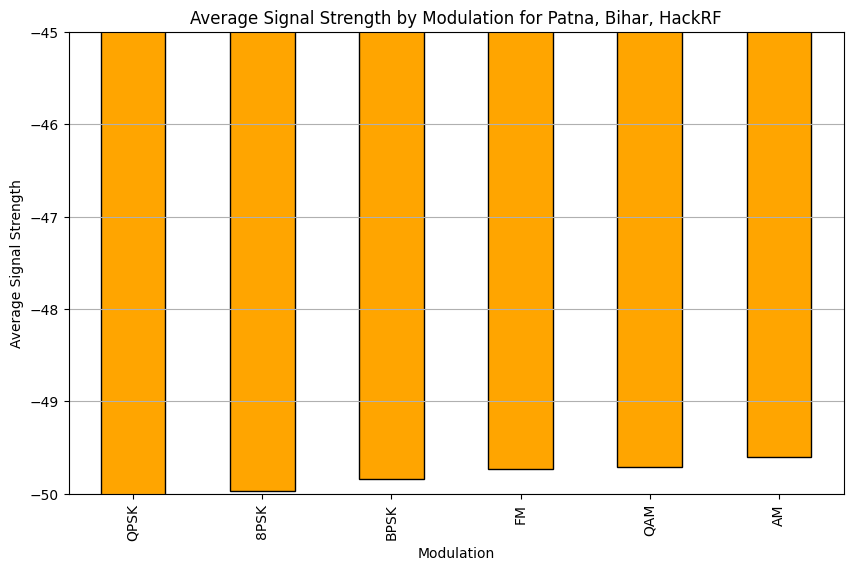

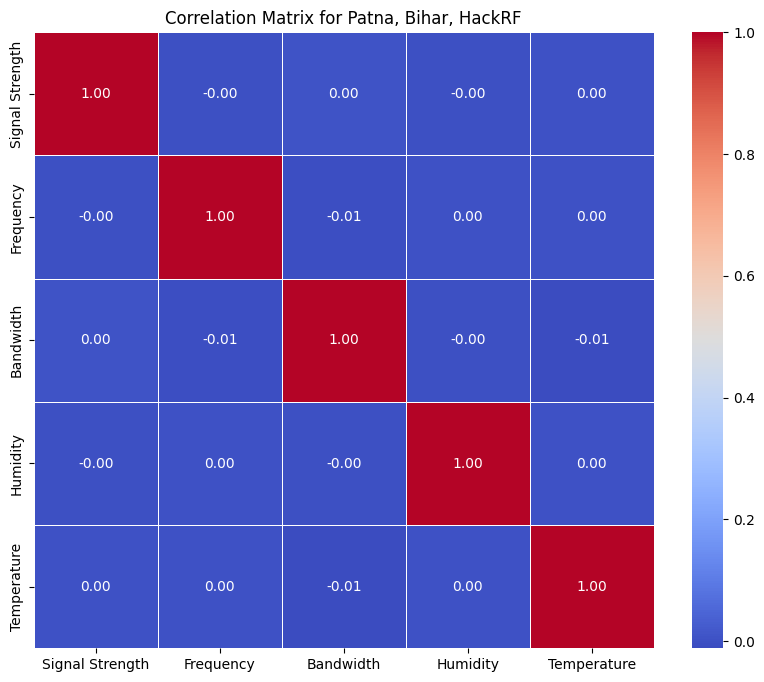

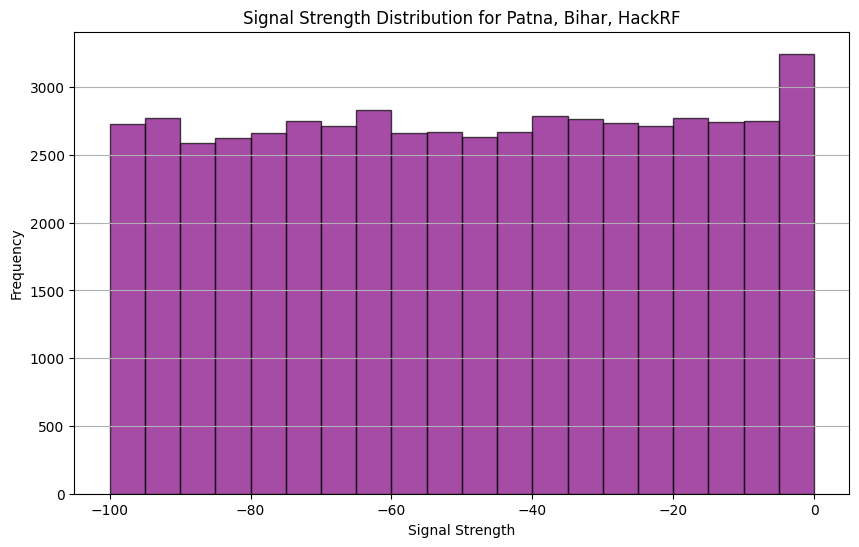

In [56]:
from matplotlib import pyplot as plt
import seaborn as sns

# Построение графиков
plt.figure(figsize=(10, 6))

location = "Patna, Bihar"
Device = "HackRF"
filtered_read_and_optimized = read_and_optimized[(read_and_optimized['Location'] == location) & (read_and_optimized['Device Type'] == Device)]

# 1. Линейный график среднего 'Signal Strength' от 'Frequency'
mean_signal_strength = filtered_read_and_optimized.groupby('Frequency')['Signal Strength'].mean().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(mean_signal_strength['Frequency'], mean_signal_strength['Signal Strength'], marker='o', color='green', alpha=0.7)
plt.title(f"Average Signal Strength vs Frequency for {location}, {Device}")
plt.xlabel('Frequency')
plt.ylabel('Average Signal Strength')
plt.grid()
plt.show()

# 2. Линейный график среднего 'Bandwidth' от 'Frequency'
mean_bandwidth = filtered_read_and_optimized.groupby('Frequency')['Bandwidth'].mean().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(mean_bandwidth['Frequency'], mean_bandwidth['Bandwidth'], marker='o', color='blue', alpha=0.7)
plt.title(f"Average Bandwidth vs Frequency for {location}, {Device}")
plt.xlabel('Frequency')
plt.ylabel('Average Bandwidth')
plt.grid()
plt.show()

# 3. Столбчатая диаграмма среднего значения 'Signal Strength' для разных 'Modulation' с ограничением оси
avg_signal_strength = filtered_read_and_optimized.groupby('Modulation')['Signal Strength'].mean().sort_values()
plt.figure(figsize=(10, 6))
avg_signal_strength.plot(kind='bar', color='orange', edgecolor='black')
plt.title(f'Average Signal Strength by Modulation for {location}, {Device}')
plt.xlabel('Modulation')
plt.ylabel('Average Signal Strength')
plt.ylim(-50, -45)
plt.grid(axis='y')
plt.show()

# 4. График корреляции величин
correlation_columns = ['Signal Strength', 'Frequency', 'Bandwidth', 'Humidity', 'Temperature']
corr_matrix = filtered_read_and_optimized[correlation_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f'Correlation Matrix for {location}, {Device}')
plt.show()

# 5. Гистограмма распределения 'Signal Strength'
plt.figure(figsize=(10, 6))
filtered_read_and_optimized['Signal Strength'].plot(kind='hist', bins=20, color='purple', edgecolor='black', alpha=0.7)
plt.title(f'Signal Strength Distribution for {location}, {Device}')
plt.xlabel('Signal Strength')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()
